In [1]:
from unidepth.models import UniDepthV2
from glob import glob
import random
import numpy as np
from matplotlib import pyplot as plt
import torch
import sklearn
from PIL import Image
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud
from nuscenes.utils.geometry_utils import transform_matrix
from pyquaternion import Quaternion
import os
from scipy.spatial import KDTree
from sklearn.preprocessing import MinMaxScaler

/home/lees/miniconda3/envs/Utest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lees/miniconda3/envs/Utest/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/lees/Desktop/UniDepth/unidepth/utils/chamfer_distance.py:9: UserWarning: !! To run evaluation you need KNN. Please compile KNN: `cd unidepth/ops/knn with && bash compile.sh`.
  warnings.warn(


# DATA HANDLING AND VISUALIZATION

In [2]:
root = "./nuscenes_mini/"

In [3]:
nusc = NuScenes(version='v1.0-mini', dataroot=root, verbose=False)
print(f"Number of samples in the dataset: {len(nusc.sample)}")
sample = nusc.sample[random.randint(0, len(nusc.sample))]

Number of samples in the dataset: 404


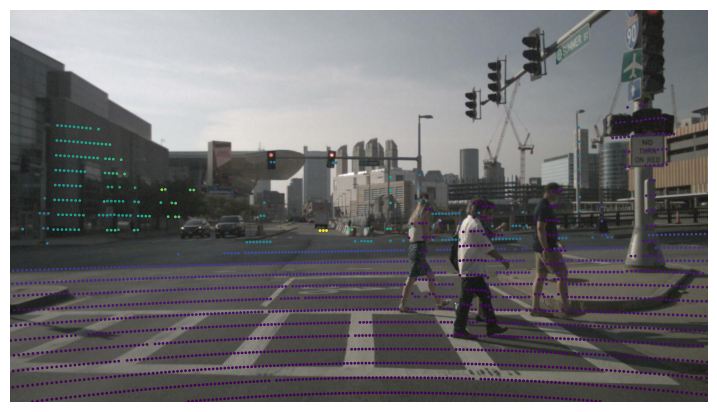

In [ ]:
nusc.render_pointcloud_in_image(sample['token'], pointsensor_channel='LIDAR_TOP', camera_channel='CAM_FRONT', dot_size=1)

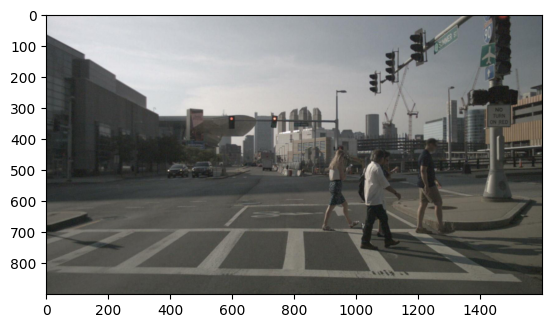

In [5]:
image_path = nusc.get('sample_data', sample['data']['CAM_FRONT'])['filename']
plt.imshow(np.array(Image.open("./nuscenes_mini/"+image_path)))

# MODEL DECLARATION AND WEIGHTS LOADING

In [9]:
model = UniDepthV2.from_pretrained("lpiccinelli/unidepth-v2-vitl14") # or "lpiccinelli/unidepth-v1-cnvnxtl" for the ConvNext backbone
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Not loading pretrained weights for backbone
EdgeGuidedLocalSSI reverts to a non cuda-optimized operation, you will experince large slowdown, please install it:  `cd ./unidepth/ops/extract_patches && bash compile.sh`


# MODEL INFERENCE AND PREDICTIONS COMPARISON

In [10]:
image = Image.open(root + image_path).convert("RGB")  # Ensure it's in RGB format

rgb = torch.as_tensor(np.array(image).astype('float')).permute(2, 0, 1)

In [8]:
# Load the RGB image and the normalization will be taken care of by the model
rgb = torch.as_tensor(np.array(image).astype('float')).permute(2, 0, 1)

predictions = model.infer(rgb)

# Metric Depth Estimation
depth = predictions["depth"]

# Point Cloud in Camera Coordinate
xyz = predictions["points"]

# Intrinsics Prediction
intrinsics = predictions["intrinsics"]

/home/lees/Desktop/UniDepth/unidepth/models/unidepthv2/unidepthv2.py:262: UserWarning: !! self.resolution_level not set, using default bounds !!
  warnings.warn("!! self.resolution_level not set, using default bounds !!")


In [11]:
camera_token = sample['data']['CAM_FRONT']
camera_data = nusc.get('sample_data', camera_token)
calibrated_sensor = nusc.get('calibrated_sensor', camera_data['calibrated_sensor_token'])

intrinsics_or = torch.as_tensor(np.array(calibrated_sensor['camera_intrinsic']).astype('float'))

predictions_wi = model.infer(rgb, intrinsics_or)

In [13]:
predictions['depth'].shape, predictions['points'].shape, predictions['intrinsics'].shape

(torch.Size([1, 1, 900, 1600]),
 torch.Size([1, 3, 900, 1600]),
 torch.Size([1, 3, 3]))

In [52]:
np.max(predictions['points'].squeeze().cpu().numpy()[0]), np.max(predictions['points'].squeeze().cpu().numpy()[1]), np.max(predictions['points'].squeeze().cpu().numpy()[2])

(271.85275, 3.0430596, 526.21747)

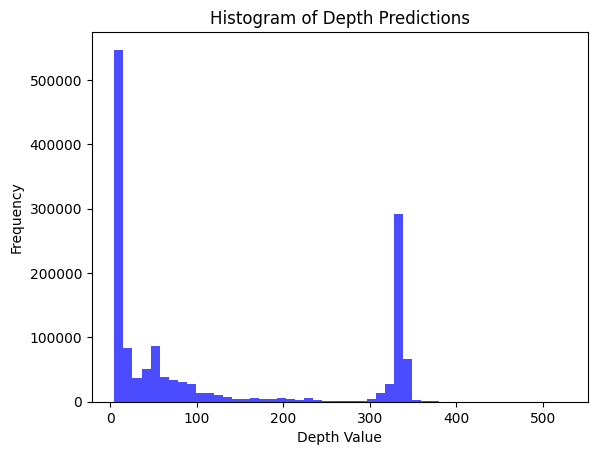

In [128]:
np.max(predictions['depth'].squeeze().cpu().numpy())
plt.hist(predictions['depth'].squeeze().cpu().numpy().flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Depth Predictions")
plt.xlabel("Depth Value")
plt.ylabel("Frequency")
plt.show()

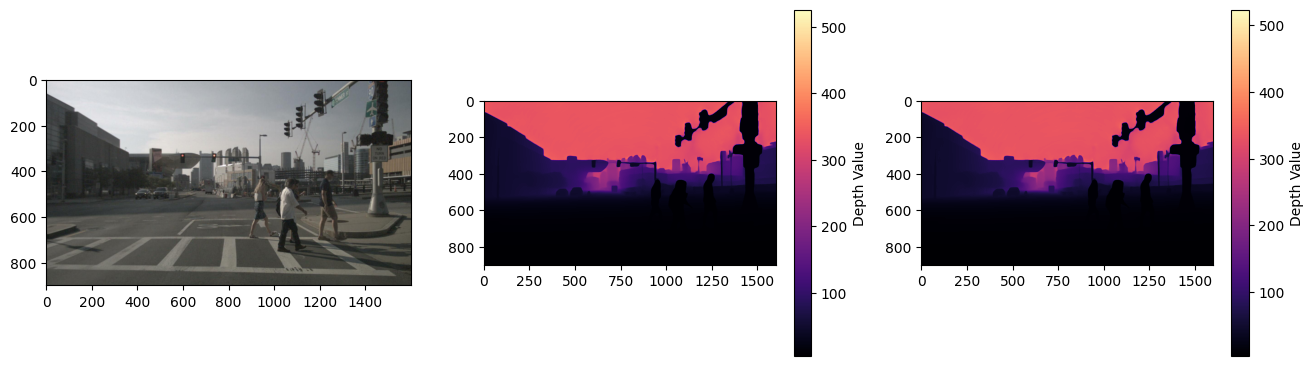

In [134]:
img = plt.imread(root+image_path)
plt.figure(figsize=(16, 9))
plt.subplot(1, 3, 1)
plt.imshow(img)

plt.subplot(1, 3, 2)
depth_image = predictions['depth'].squeeze().cpu().numpy()
plt.imshow(depth_image, cmap='magma')
plt.colorbar(label="Depth Value", shrink=0.5)

plt.subplot(1, 3, 3)
depth_image_wi = predictions_wi['depth'].squeeze().cpu().numpy()
plt.imshow(depth_image_wi, cmap='magma')
plt.colorbar(label="Depth Value", shrink=0.5)


plt.show()

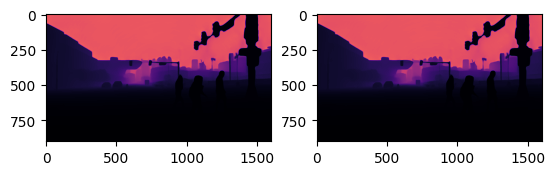

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(predictions['depth'].squeeze().cpu().numpy(), cmap='magma')

plt.subplot(1, 2, 2)
plt.imshow(predictions_wi['depth'].squeeze().cpu().numpy(), cmap='magma')


plt.show()

# LIDAR AND RADAR FUSION 

In [ ]:
lidar_token = sample['data']['LIDAR_TOP']
lidar_sd_record = nusc.get('sample_data', lidar_token)
lidar_cs_record = nusc.get('calibrated_sensor', lidar_sd_record['calibrated_sensor_token'])
ego_pose_lidar = nusc.get('ego_pose', lidar_sd_record['ego_pose_token'])



pc = LidarPointCloud.from_file(nusc.get_sample_data_path(lidar_token))
# ----------------------------------------------------------------
# STEP 2: GET CAMERA INFORMATION
# ----------------------------------------------------------------
cam_token = sample['data']['CAM_FRONT']
cam_sd_record = nusc.get('sample_data', cam_token)
# Camera intrinsic matrix stored in the sample_data record
cam_cs_record = nusc.get('calibrated_sensor', cam_sd_record['calibrated_sensor_token'])
ego_pose_cam = nusc.get('ego_pose', cam_sd_record['ego_pose_token'])
cam_intrinsic = np.array(cam_cs_record['camera_intrinsic'])

# ----------------------------------------------------------------
# STEP 3: COMPUTE TRANSFORMATION MATRICIES
# ----------------------------------------------------------------
# Get sensor calibration and ego pose info for LIDAR

T_lidar2ego = transform_matrix(lidar_cs_record['translation'], Quaternion(lidar_cs_record['rotation']), inverse=False)
T_ego2global_lidar = transform_matrix(ego_pose_lidar['translation'], Quaternion(ego_pose_lidar['rotation']), inverse=False)

# Get sensor calibration and ego pose info for Camera
T_ego2cam = transform_matrix(cam_cs_record['translation'], Quaternion(cam_cs_record['rotation']), inverse=False)
# Invert camera ego pose to go from global to camera ego frame
T_global2ego_cam = transform_matrix(ego_pose_cam['translation'], Quaternion(ego_pose_cam['rotation']), inverse=True)

# Compose the overall transformation from LIDAR coordinates to Camera coordinates:
# T_lidar2cam = T_ego2cam * T_global2ego_cam * T_ego2global_lidar * T_lidar2ego
T_lidar2cam = T_ego2cam @ T_global2ego_cam @ T_ego2global_lidar @ T_lidar2ego

# ----------------------------------------------------------------
# STEP 4: TRANSFORM AND PROJECT POINT CLOUD
# ----------------------------------------------------------------
# Convert to homogeneous coordinates (4xN)
points_homogeneous = np.vstack((pc.points[:3, :], np.ones((1, pc.points.shape[1]))))
# Transform points from LIDAR to Camera frame
points_cam = T_lidar2cam @ points_homogeneous

# Filter out points that are behind the camera (z <= 0)
in_front = points_cam[2, :] > 0
points_cam = points_cam[:, in_front]

# Project the 3D points onto the 2D image plane using the camera intrinsic matrix
points_2d = cam_intrinsic @ points_cam[:3, :]
# Normalize homogeneous coordinates (divide by z)
points_2d[:2, :] /= points_2d[2, :]

# Transpose to get an array of shape (N, 2), where each row is (u, v) pixel coordinate
uv_pixels = points_2d[:2, :].T

# Filter points that are within the image boundaries
image_width, image_height = img.shape[1], img.shape[0]
inside_image = (uv_pixels[:, 0] >= 0) & (uv_pixels[:, 0] < image_width) & \
               (uv_pixels[:, 1] >= 0) & (uv_pixels[:, 1] < image_height)
uv_pixels = uv_pixels[inside_image]
print("Filtered points shape:", uv_pixels.shape)


print("Projected pixel coordinates shape:", uv_pixels.shape)
print("First few pixel coordinates:\n", uv_pixels[:5])

Filtered points shape: (3608, 2)
Projected pixel coordinates shape: (3608, 2)
First few pixel coordinates:
 [[9.37135842e+02 1.32905817e+00]
 [1.00154346e+03 1.42390275e+00]
 [1.03103568e+03 6.41980960e-01]
 [1.05963423e+03 2.09818999e-01]
 [9.76707844e+02 3.31311694e+00]]


In [123]:
np.max(uv_pixels[:, 0]), np.max(uv_pixels[:, 1]), np.min(uv_pixels[:, 0]), np.min(uv_pixels[:, 1])

(1340.2505701648927, 899.9454540198395, 865.0830810237504, 0.2098189986682121)

In [124]:
uv_pixels_rounded = np.round(uv_pixels).astype(int)
np.max(uv_pixels_rounded[:, 0]), np.max(uv_pixels_rounded[:, 1]), np.min(uv_pixels_rounded[:, 0]), np.min(uv_pixels_rounded[:, 1])

(1340, 900, 865, 0)

In [102]:
lidar_token = sample['data']['LIDAR_TOP']
lidar_data = nusc.get('sample_data', lidar_token)
lidar_path = os.path.join(nusc.dataroot, lidar_data['filename'])

pc_lidar = LidarPointCloud.from_file(lidar_path)


# Transform to ego vehicle frame at timestamp
cs_record = nusc.get('calibrated_sensor', lidar_data['calibrated_sensor_token'])
rotation = Quaternion(cs_record['rotation'])
lidar_to_ego = transform_matrix(cs_record['translation'], rotation, inverse=False)
pc_lidar.transform(lidar_to_ego)
pc_lidar.points.shape, np.max(pc_lidar.points[0]), np.max(pc_lidar.points[1]), np.max(pc_lidar.points[2]), np.max(pc_lidar.points[3])

((4, 34752), 100.68477, 76.44302, 13.451851, 255.0)

In [103]:
camera_token = sample['data']['CAM_FRONT']
cam_data = nusc.get('sample_data', camera_token)
cs_record_cam = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
cam_rotation = Quaternion(cs_record_cam['rotation'])
ego_to_cam = transform_matrix(cs_record_cam['translation'], cam_rotation, inverse=False)

# Transform LiDAR points from ego vehicle frame to camera frame:
pc_lidar.transform(ego_to_cam)
pc_lidar.points.shape, np.max(pc_lidar.points[0]), np.max(pc_lidar.points[1]), np.max(pc_lidar.points[2]), np.max(pc_lidar.points[3])

((4, 34752), 16.115849, 85.492805, 61.06858, 255.0)

In [74]:
radar_channels = ['RADAR_FRONT', 'RADAR_FRONT_LEFT', 'RADAR_FRONT_RIGHT', 
                  'RADAR_BACK_LEFT', 'RADAR_BACK_RIGHT']

radar_points = []

for channel in radar_channels:
    radar_token = sample['data'][channel]
    radar_data = nusc.get('sample_data', radar_token)
    radar_path = os.path.join(nusc.dataroot, radar_data['filename'])

    pc_radar = RadarPointCloud.from_file(radar_path)

    cs_record = nusc.get('calibrated_sensor', radar_data['calibrated_sensor_token'])
    rotation = Quaternion(cs_record['rotation'])
    radar_to_ego = transform_matrix(cs_record['translation'], rotation, inverse=False)
    pc_radar.transform(radar_to_ego)

    radar_points.append(pc_radar.points)  # Only x, y, z for now

# Stack all radar into one array
radar_combined = np.hstack(radar_points)
print(f"Combined radar points shape: {radar_combined.shape}")

Combined radar points shape: (18, 163)


In [19]:
lidar_points = pc_lidar.points[:3, :]  # shape: (3, N)
all_points = np.hstack((lidar_points, radar_combined))  # shape: (3, N+M)

In [20]:
points_np = all_points.T  # shape: (N, 3)

In [22]:
def project_points_to_camera_plane(points, intrinsics):
    """
    Projects 3D points into the camera plane using the intrinsic matrix.

    Args:
        points (numpy.ndarray): 3D points of shape (3, N).
        intrinsics (torch.Tensor): Camera intrinsic matrix of shape (3, 3).

    Returns:
        numpy.ndarray: 2D projected points of shape (2, N).
    """
    # Convert intrinsics to numpy if it's a torch tensor
    if isinstance(intrinsics, torch.Tensor):
        intrinsics = intrinsics.cpu().numpy()

    # Homogeneous coordinates
    points_homogeneous = np.vstack((points, np.ones((1, points.shape[1]))))  # Shape: (4, N)

    # Project points
    projected_points = intrinsics @ points_homogeneous[:3, :]  # Shape: (3, N)

    # Normalize by the third coordinate to get 2D points
    projected_points /= projected_points[2, :]

    return projected_points[:2, :]

# Project lidar points into the camera plane
projected_points = project_points_to_camera_plane(all_points, intrinsics_or)

# Print shapes of the projected points
print(f"Projected Lidar Points Shape: {projected_points.shape}")

Projected Lidar Points Shape: (2, 34915)


# PREDICTED POINTCLOUD VS ORIGINAL POINTCLOUD

In [23]:
def xyz_coords_conversion(vett1):

    H, W = vett1.shape
        
    # Creiamo una griglia di coordinate
    y_coords, x_coords = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')

    # Flatten delle coordinate per ottenere shape (1, H*W)
    x_flat = x_coords.flatten()
    y_flat = y_coords.flatten()

    # Stack delle coordinate per ottenere shape (2, H*W)
    vett_xyz = np.vstack((x_flat, y_flat))
    # Ensure vett1 is a numpy array
    vett1 = np.array(vett1)

    # Flatten and stack the coordinates
    vett_xyz = np.vstack((vett_xyz, vett1.flatten()))

    return vett_xyz

In [24]:
xyz_pred = xyz_coords_conversion(predictions['depth'].squeeze().cpu().numpy())

xyz_pred.shape, all_points.shape

((3, 1440000), (3, 34915))

In [25]:
np.max(xyz_pred[0]), np.max(xyz_pred[1]), np.max(xyz_pred[2])

(1599.0, 899.0, 526.2174682617188)

In [26]:
np.max(all_points[0]), np.max(all_points[1]), np.max(all_points[2])

(236.42911373502346, 98.3189192402545, 13.451850891113281)

In [27]:
xyz_pred_scaled = xyz_pred.copy()
all_points_scaled = all_points.copy()

scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0,1)
xyz_pred_scaled = np.vstack([scaler.fit_transform(xyz_pred[i, :].reshape(-1, 1)).flatten() for i in range(xyz_pred.shape[0])])
all_points_scaled = np.vstack([scaler.fit_transform(all_points[i, :].reshape(-1, 1)).flatten() for i in range(all_points.shape[0])])

In [29]:
print(xyz_pred_scaled[0], xyz_pred_scaled[1], xyz_pred_scaled[2])
print(all_points_scaled[0], all_points_scaled[1], all_points_scaled[2])

[0.00000000e+00 6.25390869e-04 1.25078174e-03 ... 9.98749218e-01
 9.99374609e-01 1.00000000e+00] [0. 0. 0. ... 1. 1. 1.] [6.72398398e-01 6.71339506e-01 6.70183835e-01 ... 1.75398859e-05
 8.26664836e-06 0.00000000e+00]
[0.48944764 0.48945569 0.48946624 ... 0.10168966 0.06326927 0.02878425] [0.53644534 0.53659001 0.53637588 ... 0.46050249 0.44135105 0.29964825] [0.30008562 0.30330691 0.30858626 ... 0.30796872 0.30796872 0.30796872]
